In [1]:
import pandas as pd

data_raw = pd.read_csv('afval_weging.csv', delimiter=';')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [56]:
data = data_raw.copy()
data['weging_datum_weging'] = pd.to_datetime(data['weging_datum_weging'])

In [3]:
data['year'] = data['weging_datum_weging'].dt.year

/Users/Arek/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


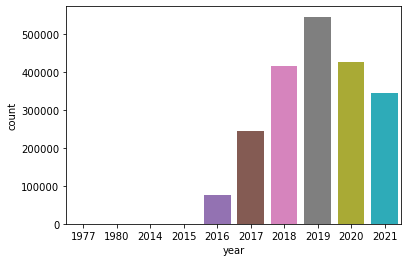

(2050497, 68)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data['year'])
plt.show()
data.shape

In [57]:
data = data[data['weging_datum_weging'].between('2017-01-01','2020-12-31')]
data.shape # 1.63M rows to work with

(1630590, 67)

In [58]:
data.describe(include = 'all').T

# cluster_id - some identification of the actual container, need to dig deeper
# weging_id - unique identifier
# weging_datum_weging - date of the weighing
# weging_fractie_omschrijving	- type of waste
# weging_eerste_weging - first weighing (container + waste)
# weging_tweede_weging - second weighing (empty container)
# weging_netto_gewicht - the difference between two above, netto weight of the waste
# weging_wgs84_lat - containers(cluster's in fact) latitude in WGS84 coordinate system
# weging_wgs84_lon - containers(cluster's in fact) longitude in WGS84 coordinate system
# gbd_ggwgebied_naam - district name
# gbd_ggwgebied_code - district identifier (one of many; this will be used to match the economical/population data)
# bag_adres_openbare_ruimte_naam - streetname of where the container is

data = data[['cluster_id','weging_id','weging_datum_weging','weging_fractie_omschrijving','weging_eerste_weging','weging_tweede_weging','weging_netto_gewicht','weging_wgs84_lat','weging_wgs84_lon','gbd_ggwgebied_naam','gbd_ggwgebied_code','bag_adres_openbare_ruimte_naam']]

In [7]:
data.shape
data.head()

,cluster_id,weging_id,weging_datum_weging,weging_fractie_omschrijving,weging_eerste_weging,weging_tweede_weging,weging_netto_gewicht,weging_wgs84_lat,weging_wgs84_lon,gbd_ggwgebied_naam,gbd_ggwgebied_code,bag_adres_openbare_ruimte_naam
0,128920.051|484940.826,10000~2017-02-17~09:12:03~26,2017-02-17,Rest,820,745.0,75.0,52.35202,5.00440,"IJburg, Zeeburgereiland",DX16,Eva Besnyöstraat
1,120064.880|486202.591,10000~2017-03-30~07:39:31~21,2017-03-30,Rest,685,585.0,100.0,52.36260,4.87426,"Oud-West, De Baarsjes",DX05,Overtoom
2,NaN,10000~2017-03-31~11:18:50~15,2017-03-31,Rest,590,-225.0,815.0,52.36653,4.86935,NaN,NaN,NaN
3,126423.325|481859.655,10000~2017-05-08~07:48:44~1,2017-05-08,Rest,1145,655.0,490.0,52.32406,4.96816,Bijlmer-Oost,DX21,Gravestein
4,121060.889|482000.344,10000~2017-12-01~13:20:22~221,2017-12-01,Rest,870,610.0,260.0,52.32489,4.88950,"Buitenveldert, Zuidas",DX11,Van Boshuizenstraat


In [59]:
# Nulls in:
# cluster_id
# bag_adres_openbare_ruimte_naam	
# bag_adres_nummeraanduiding_postcode	
# bag_openbareruimte_naam	
# gbd_stadsdeel_naam	
# gbd_wijk_naam

data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.shape # #1.35M left, acceptable & nulls cannot really be attributed back to their true locations

(1349239, 12)

In [60]:
data['calculated_net'] = data['weging_eerste_weging']-data['weging_tweede_weging']

 0.0       1247289
-10.0         6645
-20.0         3350
-30.0         2269
-40.0         1381
            ...   
-2195.0          1
-2175.0          1
 55.0            1
-2155.0          1
-3815.0          1
Name: diff, Length: 976, dtype: int64

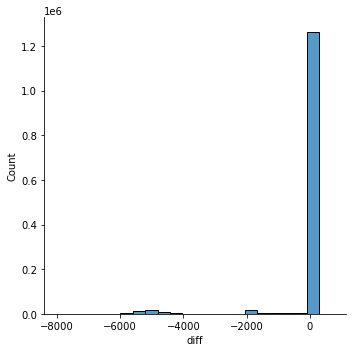

(1349239, 14)

In [66]:
data['diff'] = data['calculated_net'] - data['weging_netto_gewicht']
display(data['diff'].value_counts())

sns.displot(data['diff']) 
plt.show()
data.shape

 0.0       17224
 175.0     16969
 190.0     16859
 180.0     16749
 170.0     16680
           ...  
 2490.0        1
 2885.0        1
 3690.0        1
 2725.0        1
-3535.0        1
Name: calculated_net, Length: 1262, dtype: int64

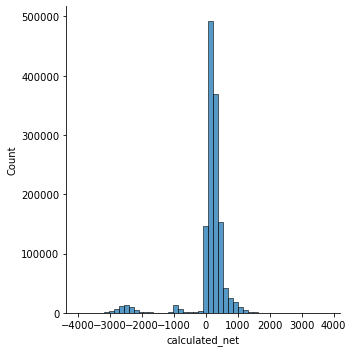

(1349239, 14)

In [62]:
display(data['calculated_net'].value_counts()) # use the calculated values and drop the negative outliers

sns.displot(data['calculated_net'], bins = 50) 
plt.show()
data.shape

In [67]:
data = data[data['calculated_net'] > 0] # exclude negatives.. makes sense

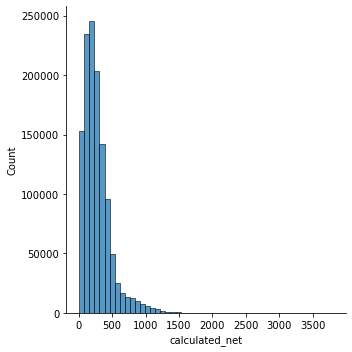

(1228430, 14)

In [68]:
sns.displot(data['calculated_net'], bins = 50) 
plt.show()
data.shape # Still at #1.2M, this will be enough

In [69]:
district = pd.read_excel('2020-22-gebieden-3-15.xlsx', engine='openpyxl')
district = district.dropna()
district.reset_index(drop=True,inplace=True)
district = district.drop([0,23])
district.columns = ['district_id','district_name','citizens_in_district','citizens_with_income','average_personal_income','number_of_households','average_household_income','ind']
district = district.drop(['ind'], axis = 1)

for column in district.columns[2:]:
    district[column] = district[column].apply(lambda x: x*1000) 
district
district.to_csv('district.csv',index=False)

In [70]:
data = data.drop(['weging_eerste_weging','weging_tweede_weging','weging_netto_gewicht','diff'], axis = 1) # drop unnecessary columns

In [71]:
# Time for RegEx KING

import re
from datetime import datetime as dt

pattern = '\d{2}:\d{2}:\d{2}'
data['time'] = 0
data['time'] = data['weging_id'].apply(lambda x: dt.strptime(re.findall(pattern, x)[0], '%H:%M:%S').time())
# created a pickup time from the unique 'weging_id' colummn, may be useful in time-analysis

In [79]:
# Cleaning the waste type column
import numpy as np

data['weging_fractie_omschrijving'] = data['weging_fractie_omschrijving'].apply(lambda x: x.capitalize())

data['weging_fractie_omschrijving'] = np.where(data['weging_fractie_omschrijving'] == 'Rest', 'Mixed waste', data['weging_fractie_omschrijving'])
data['weging_fractie_omschrijving'] = np.where(data['weging_fractie_omschrijving'] == 'Papier', 'Paper', data['weging_fractie_omschrijving'])
data['weging_fractie_omschrijving'] = np.where(data['weging_fractie_omschrijving'] == 'Glas', 'Glass', data['weging_fractie_omschrijving'])
data['weging_fractie_omschrijving'] = np.where(data['weging_fractie_omschrijving'] == 'Kunststof', 'Plastic', data['weging_fractie_omschrijving'])
data['weging_fractie_omschrijving'] = np.where(data['weging_fractie_omschrijving'] == 'Textiel', 'Textiles', data['weging_fractie_omschrijving'])
display(data['weging_fractie_omschrijving'].value_counts())

Mixed waste    1021708
Paper           100798
Plastic          65020
Glass            40888
Textiles            16
Name: weging_fractie_omschrijving, dtype: int64

In [80]:
# Change column names & order
data.columns = ['cluster_id',
                'waste_id',
                'waste_date',
                'waste_type',
                'cluster_lat',
                'cluster_lon',
                'district_name',
                'district_id',
                'street_name',
                'waste_weight',
                'waste_time']

data = data[['waste_id','cluster_id','cluster_lat','cluster_lon','waste_date','waste_time','waste_type','waste_weight','district_id','district_name','street_name']]

In [81]:
data

,waste_id,cluster_id,cluster_lat,cluster_lon,waste_date,waste_time,waste_type,waste_weight,district_id,district_name,street_name
0,10000~2017-02-17~09:12:03~26,128920.051|484940.826,52.35202,5.00440,2017-02-17,09:12:03,Mixed waste,75.0,DX16,"IJburg, Zeeburgereiland",Eva Besnyöstraat
1,10000~2017-03-30~07:39:31~21,120064.880|486202.591,52.36260,4.87426,2017-03-30,07:39:31,Mixed waste,100.0,DX05,"Oud-West, De Baarsjes",Overtoom
2,10000~2017-05-08~07:48:44~1,126423.325|481859.655,52.32406,4.96816,2017-05-08,07:48:44,Mixed waste,490.0,DX21,Bijlmer-Oost,Gravestein
3,10000~2017-12-01~13:20:22~221,121060.889|482000.344,52.32489,4.88950,2017-12-01,13:20:22,Mixed waste,260.0,DX11,"Buitenveldert, Zuidas",Van Boshuizenstraat
4,10000~2017-12-22~08:20:49~37,123789.260|485255.579,52.35434,4.92904,2017-12-22,08:20:49,Mixed waste,160.0,DX15,Watergraafsmeer,Wakkerstraat
...,...,...,...,...,...,...,...,...,...,...,...
1349233,9~2020-01-24~08:19:15~30,124324.612|485506.262,52.35671,4.93702,2020-01-24,08:19:15,Mixed waste,150.0,DX15,Watergraafsmeer,Newtonstraat
1349234,1001~2020-06-30~09:12:52~17,119059.610|485875.456,52.35950,4.85941,2020-06-30,09:12:52,Plastic,70.0,DX05,"Oud-West, De Baarsjes",J.J. Cremerplein
1349236,1001~2020-08-17~10:03:11~27,122807.846|484956.974,52.35159,4.91487,2020-08-17,10:03:11,Mixed waste,225.0,DX13,Oud-Oost,Hofmeyrstraat
1349237,1001~2020-08-17~10:58:33~28,122558.468|485631.864,52.35764,4.91084,2020-08-17,10:58:33,Mixed waste,130.0,DX13,Oud-Oost,Ruyschstraat


In [82]:
# Ready to roll
data.reset_index(drop=True, inplace=True)
data.to_csv('data_clean.csv',index=False)

In [ ]:
# Tableau Visualization of the above data
# https://public.tableau.com/views/WhatDoRichDitch/WasteTypebyDistrict?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link